In [375]:
## set those accordingly
datadir = '../Datasets/'
abcd_path = '/Users/user/Downloads/GraphMiningNotebooks-master-3/utils/'
#abcd_path = '~/ABCD/utils/'

In [376]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI

## we use those for the book, but you can change for other colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

## Question 1: 
#### (P) Re-do the experiment used to generate Figure 5.15 but addi-tionally include the Girvan-Newman algorithm. That is, for each graph tested, run the Girvan-Newman algorithm, select the partition with the highest modularity, and use it for comparison to the ground-truth (AMI). (If the experiment is slow, then generate only, say, 3 graphs instead of 30.)

In [378]:
## This can take a while in view of the number of runs, mainly due to the clustering algorithms
## You can reduce the number of repeats (REP) for a faster test

L = []   ## store results in a list
REP = 3  ## number of graphs for each value of xi
XIs = [x/100 for x in np.arange(10,81,5)] ## values for xi

for rep in range(REP):
    print('repeat number',rep)
    ## generate new degree and community size values
    cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat 2.5 10 50 300 300'
    os.system(cmd)
    cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat 1.5 50 100 300 300'
    os.system(cmd)
    
    ## generate graphs for a range of xi 
    for xi in XIs:
        cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat '\
                +str(xi)+' false false'
        os.system(cmd)
        
        ## compute AMI for various clustering algorithms
        g = ig.Graph.Read_Ncol('net.dat',directed=False)
        g.vcount()
        
        
        c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
        g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]
        
         ## clustering
        L.append(['Infomap',xi,AMI(g.community_infomap().membership,g.vs['comm'])])
        L.append(['ECG',xi,AMI(g.community_ecg().membership,g.vs['comm'])])
        L.append(['Louvain',xi,AMI(g.community_multilevel().membership,g.vs['comm'])])
        L.append(['Label Prop.',xi,AMI(g.community_label_propagation().membership,g.vs['comm'])])
        
        gn = g.community_edge_betweenness()
        q = []
        a = []
        for i in np.arange(g.vcount()):
            q.append(g.modularity(gn.as_clustering(n=i+1)))
            a.append(AMI(g.vs['comm'],gn.as_clustering(n=i+1).membership))
        df = pd.DataFrame((np.round(q,2), np.round(a,2)))
        df = df.T
        df1 = df[df[0]>=df[0].max()]
        am1 = list(df1[1])
        L.append(["Girvan_newman",xi,am1[0]])

repeat number 0
repeat number 1
repeat number 2


#### Standard Deviations

In [380]:
D = pd.DataFrame(L,columns=['algo','xi','AMI'])
D.value_counts()

algo           xi    AMI          
ECG            0.10   1.000000e+00    3
Girvan_newman  0.65   0.000000e+00    3
Louvain        0.10   1.000000e+00    3
Label Prop.    0.10   1.000000e+00    3
Infomap        0.30   1.000000e+00    3
                                     ..
Louvain        0.40   9.251542e-01    1
Infomap        0.55  -5.288498e-16    1
Louvain        0.35   1.000000e+00    1
Infomap        0.60  -5.288498e-16    1
Louvain        0.80   1.113647e-02    1
Length: 156, dtype: int64

In [381]:
S = D.groupby(by=['algo','xi']).std()
S

AMI
algo    xi            
ECG     0.10  0.000000
        0.15  0.000000
        0.20  0.000000
        0.25  0.000000
        0.30  0.000000
...                ...
Louvain 0.60  0.006795
        0.65  0.010876
        0.70  0.005405
        0.75  0.005405
        0.80  0.005405

[75 rows x 1 columns]

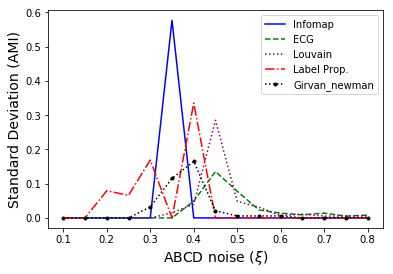

In [383]:
a = ['Infomap','ECG','Louvain','Label Prop.','Girvan_newman']
lt = ['-','--',':','-.','.:']
cl = ['blue','green','purple','red','black']
for i in range(len(a)):
    #plt.plot(S.loc[(a[i])].index,S.loc[(a[i])],lt[i],label=a[i],color=cl[i])
    plt.plot(S.loc[(a[i])].index,S.loc[(a[i])],lt[i],label=a[i],color= cl[i])
plt.xlabel(r'ABCD noise ($\xi$)',fontsize=14)
plt.ylabel('Standard Deviation (AMI)',fontsize=14)
plt.legend();

In [384]:
## This can take a while in view of the number of runs, mainly due to the clustering algorithms
## You can reduce the number of repeats (REP) for a faster test

Ls = []   ## store results in a list
REP =3  ## number of graphs for each value of xi
XIs = [x/100 for x in np.arange(10,81,5)] ## values for xi

for rep in range(REP):
    print('repeat number',rep)
    ## generate new degree and community size values
    cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat 2.5 10 50 300 300'
    os.system(cmd)
    cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat 1.5 50 100 300 300'
    os.system(cmd)
    
    ## generate graphs for a range of xi 
    for xi in XIs:
        cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat '\
                +str(xi)+' false false'
        os.system(cmd)
        
        
        ## compute AMI running various clustering algorithms twice
        g = ig.Graph.Read_Ncol('net.dat',directed=False)
        ml1 = g.community_multilevel().membership
        ec1 = g.community_ecg().membership
        lp1 = g.community_label_propagation().membership
        im1 = g.community_infomap().membership
        ## permute vertices
        idx = np.random.permutation(g.vcount())
        gp = ig.Graph.Erdos_Renyi(n=g.vcount(),p=0)
        for e in g.es():
            gp.add_edge(idx[e.tuple[0]],idx[e.tuple[1]])
        ml = gp.community_multilevel().membership
        ml2 = [ml[idx[i]] for i in range(len(idx))]
        ec = gp.community_ecg().membership
        ec2 = [ml[idx[i]] for i in range(len(idx))]
        lp = gp.community_label_propagation().membership
        lp2 = [lp[idx[i]] for i in range(len(idx))]
        im = gp.community_infomap().membership
        im2 = [im[idx[i]] for i in range(len(idx))]        
        Ls.append(['ECG',xi,AMI(ec1,ec2)])
        Ls.append(['Louvain',xi,AMI(ml1,ml2)])
        Ls.append(['Label Prop.',xi,AMI(lp1,lp2)])
        Ls.append(['Infomap',xi,AMI(im1,im2)])
         
        c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
        g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]
        
        #running Girvan-newman algorithm and computing AMI twice and then appending the Ls list.
        gn = g.community_edge_betweenness()
        q = []
        a = []
        for i in np.arange(g.vcount()):
            q.append(g.modularity(gn.as_clustering(n=i+1)))
            a.append(AMI(g.vs['comm'],gn.as_clustering(n=i+1).membership))
        for i in np.arange(g.vcount()):
            q.append(g.modularity(gn.as_clustering(n=i+1)))
            a.append(AMI(g.vs['comm'],gn.as_clustering(n=i+1).membership))
        df = pd.DataFrame((np.round(q,2), np.round(a,2)))
        df = df.T
        df1 = df[df[0]>=df[0].max()]
        am1 = list(df1[1])        
        Ls.append(['Girvan_newman',xi,am1[0]])

repeat number 0
repeat number 1
repeat number 2


In [390]:
D = pd.DataFrame(Ls,columns=['algo','xi','AMI'])
X = D.groupby(by=['algo','xi']).mean()

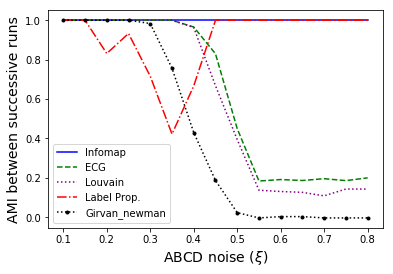

In [388]:
a = ['Infomap','ECG','Louvain','Label Prop.','Girvan_newman']
lt = ['-','--',':','-.','.:']
cl = ['blue','green','purple','red','black']
for i in range(len(a)):
    #plt.plot(S.loc[(a[i])].index,S.loc[(a[i])],lt[i],label=a[i],color=cl[i])
    plt.plot(X.loc[(a[i])].index,X.loc[(a[i])],lt[i],label=a[i],color= cl[i])
plt.xlabel(r'ABCD noise ($\xi$)',fontsize=14)
plt.ylabel('AMI between successive runs',fontsize=14)
plt.legend();

In [406]:
## This can take a while in view of the number of runs, mainly due to the clustering algorithms
## You can reduce the number of repeats (REP) for a faster test

Ls = []   ## store results in a list
REP =3  ## number of graphs for each value of xi
XIs = [x/100 for x in np.arange(10,81,5)] ## values for xi

for rep in range(REP):
    print('repeat number',rep)
    ## generate new degree and community size values
    cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat 2.5 10 50 300 300'
    os.system(cmd)
    cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat 1.5 50 100 300 300'
    os.system(cmd)
    
    ## generate graphs for a range of xi 
    for xi in XIs:
        cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat '\
                +str(xi)+' false false'
        os.system(cmd)
        
        
        ## compute AMI running various clustering algorithms twice
        g = ig.Graph.Read_Ncol('net.dat',directed=False)
        ml1 = g.community_multilevel().membership
        ec1 = g.community_ecg().membership
        lp1 = g.community_label_propagation().membership
        im1 = g.community_infomap().membership
        ## permute vertices
        idx = np.random.permutation(g.vcount())
        gp = ig.Graph.Erdos_Renyi(n=g.vcount(),p=0)
        for e in g.es():
            gp.add_edge(idx[e.tuple[0]],idx[e.tuple[1]])
        ml = gp.community_multilevel().membership
        ml2 = [ml[idx[i]] for i in range(len(idx))]
        ec = gp.community_ecg().membership
        ec2 = [ml[idx[i]] for i in range(len(idx))]
        lp = gp.community_label_propagation().membership
        lp2 = [lp[idx[i]] for i in range(len(idx))]
        im = gp.community_infomap().membership
        im2 = [im[idx[i]] for i in range(len(idx))]        
        Ls.append(['ECG',xi,AMI(ec1,ec2)])
        Ls.append(['Louvain',xi,AMI(ml1,ml2)])
        Ls.append(['Label Prop.',xi,AMI(lp1,lp2)])
        Ls.append(['Infomap',xi,AMI(im1,im2)])
         
        c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
        g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]
        
        #running Girvan-newman algorithm and computing AMI twice and then appending the Ls list.
        gn = g.community_edge_betweenness()
        q = []
        a = []
        for i in np.arange(g.vcount()):
            q.append(g.modularity(gn.as_clustering(n=i+1)))
            a.append(AMI(g.vs['comm'],gn.as_clustering(n=i+1).membership))
            
        idx = np.random.permutation(g.vcount())
        gp = ig.Graph.Erdos_Renyi(n=g.vcount(),p=0)
        for e in g.es():
            gp.add_edge(idx[e.tuple[0]],idx[e.tuple[1]])
        
        gn1 = gp.community_edge_betweenness()
        q1 = []
        a1 = []
        for i in np.arange(gp.vcount()):
            q1.append(gp.modularity(gn1.as_clustering(n=i+1)))
            a1.append(AMI(g.vs['comm'],gn1.as_clustering(n=i+1).membership))    
            
        df = pd.DataFrame((np.round(q,2), np.round(a,2),np.round(q1,2), np.round(a1,2)))
        df = df.T
        df1 = df[(df[0]>=df[0].max()) & (df[2]>=df[2].max())]
        am1 = list(df1[1])        
        Ls.append(['Girvan_newman',xi,np.mean(am1)])

repeat number 0
repeat number 1
repeat number 2


In [407]:
D = pd.DataFrame(Ls,columns=['algo','xi','AMI'])
X = D.groupby(by=['algo','xi']).mean()
X

AMI
algo    xi            
ECG     0.10  1.000000
        0.15  1.000000
        0.20  1.000000
        0.25  1.000000
        0.30  1.000000
...                ...
Louvain 0.60  0.126026
        0.65  0.133407
        0.70  0.158243
        0.75  0.136351
        0.80  0.094479

[75 rows x 1 columns]

/Users/user/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


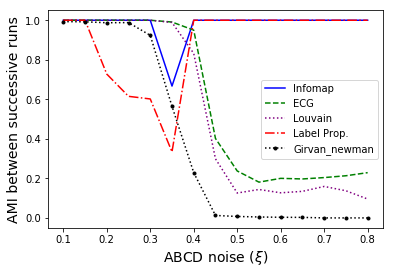

In [408]:
a = ['Infomap','ECG','Louvain','Label Prop.','Girvan_newman']
lt = ['-','--',':','-.','.:']
cl = ['blue','green','purple','red','black']
for i in range(len(a)):
    #plt.plot(S.loc[(a[i])].index,S.loc[(a[i])],lt[i],label=a[i],color=cl[i])
    plt.plot(X.loc[(a[i])].index,X.loc[(a[i])],lt[i],label=a[i],color= cl[i])
plt.xlabel(r'ABCD noise ($\xi$)',fontsize=14)
plt.ylabel('AMI between successive runs',fontsize=14)
plt.legend();

## Question 2 :  
#### (P) TakeABCDgraph we used to test quality measures (see Figure  5.10).  Check  node  roles.  Compute  how  many  nodes  we  have in each family (recall that there are 4 families of non-hubs and 3 families of hubs). Plot (z(v);p(v)) scores all all nodes as we did inFigure 5.3 for the karate club graph

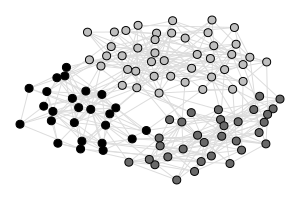

In [90]:
## read graph and communities
g = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_100.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_100_comms.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1]-1 for x in g.vs]
gt = {k:(v-1) for k,v in enumerate(g.vs['comm'])}
## map between int(name) to key
n2k = {int(v):k for k,v in enumerate(g.vs['name'])}
g.vs['size'] = 8
g.es['color'] = cls_edges
g.vs['color'] = [cls[i] for i in g.vs['comm']]
ig.plot(g, bbox=(0,0,300,200))

In [91]:
## internal degrees
in_deg_0 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==0 and g.vs['comm'][e.tuple[1]]==0],
                            delete_vertices=False).degree()
in_deg_1 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==1 and g.vs['comm'][e.tuple[1]]==1],
                            delete_vertices=False).degree()
in_deg_2 = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==2 and g.vs['comm'][e.tuple[1]]==2],
                            delete_vertices=False).degree()

## compute z (normalized within-module degree)
g.vs['in_deg'] = [in_deg_0[i] + in_deg_1[i] for i in range(g.vcount())]
mu = [np.mean(in_deg_0),np.mean(in_deg_1),np.mean(in_deg_2)]
sig = [np.std(in_deg_0),np.std(in_deg_1),np.std(in_deg_2)]

In [92]:

g.vs['z'] = [(v['in_deg']-mu[v['comm']])/sig[v['comm']] for v in g.vs]


## computing p (participation coefficient)
g.vs['deg'] = g.degree()
g.vs['out_deg'] = [v['deg'] - v['in_deg'] for v in g.vs]
g.vs['p'] = [1-(v['in_deg']/v['deg'])**2-(v['out_deg']/v['deg'])**2 for v in g.vs]
D = pd.DataFrame(np.array([g.vs['z'],g.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
D.head(8)

,z,p
2,2.879925,0.277778
31,2.879925,0.165289
32,2.527856,0.180000
24,2.521735,0.260355
37,2.220092,0.000000
22,2.220092,0.355030
48,2.220092,0.165289
9,2.175787,0.197531


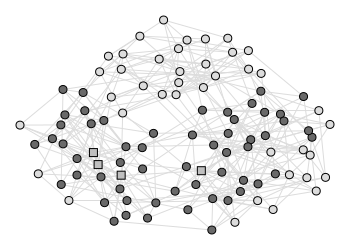

In [93]:
## plotting w.r.t. z (z>2.5 are hubs)
## color positive values in dark, negative in white
## largest values for node 0 (instructor) and node 33 (president) and node 32
g.vs['color'] = 'black'
g.vs['shape'] = 'circle'
for v in g.vs:
    if v['z']<2.5: ## non-hub
        if v['p'] < .62 and v['p'] >= .05: ## peripheral
            v['color'] = 'dimgrey'
        if v['p'] < .05: ## ultra-peripheral
            v['color'] = 'gainsboro'
    if v['z']>=2.5 and v['p'] < .3: ## hubs (all provincial here)            
        v['color'] = 'silver'
        v['shape'] = 'square'
#ig.plot(z, 'zachary_roles_1.eps', bbox=(0,0,350,250))
ig.plot(g, bbox=(0,0,350,250))

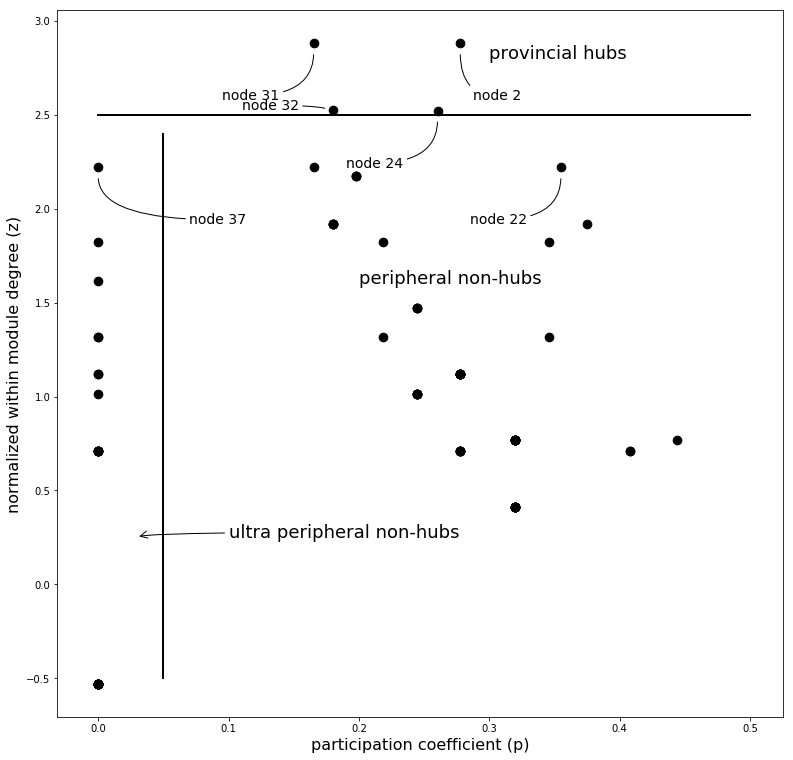

In [112]:
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(g.vs['p'],g.vs['z'],marker='o',s=75, color='k')

plt.plot([0, .5], [2.5, 2.5], color='k', linestyle='-', linewidth=2)
plt.plot([.05, .05], [-.5, 2.4], color='k', linestyle='-', linewidth=2)

ax.annotate('node 2', (g.vs['p'][2],g.vs['z'][2]-.05), xytext=(g.vs['p'][2]+.01,g.vs['z'][2]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 31', (g.vs['p'][31],g.vs['z'][31]-.05), xytext=(g.vs['p'][31]-.07,g.vs['z'][31]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 32', (g.vs['p'][32]-.005,g.vs['z'][32]), xytext=(g.vs['p'][32]-.07,g.vs['z'][32]), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 24', (g.vs['p'][24],g.vs['z'][24]-.05), xytext=(g.vs['p'][24]-.07,g.vs['z'][24]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 37', (g.vs['p'][37],g.vs['z'][37]-.05), xytext=(g.vs['p'][37]+.07,g.vs['z'][37]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('node 22', (g.vs['p'][22],g.vs['z'][22]-.05), xytext=(g.vs['p'][22]-.07,g.vs['z'][22]-.3), 
            fontsize=14,
            arrowprops = dict(  arrowstyle="-",connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('provincial hubs',(.3,2.8), fontsize=18)
ax.annotate('peripheral non-hubs',(.2,1.6), fontsize=18)
ax.annotate('ultra peripheral non-hubs',(.03,0.25),xytext=(.1,0.25), fontsize=18,
             arrowprops = dict( arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))

plt.xlabel('participation coefficient (p)',fontsize=16)
plt.ylabel('normalized within module degree (z)',fontsize=16);
#plt.savefig('zachary_roles_2.eps')

## Question 3
#### (P) Compare time complexities of various clustering algorithms (ECG, Louvain, Infomap, Label Propagation, Girvan-Newman, CNM) using ABCD synthetic graph with different number of vertices, say, n = 100; 200; 400; 800; 1600; : : :. Which algorithm is the slowest, which one is the fastest?

#### Number of vertices = 100

In [115]:
g = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_100.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_100_comms.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]

In [116]:
#Runtime of ECG clustering algorithm
import time
current_time = time.time()
g_ecg = g.community_ecg().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.0221860408782959


In [117]:
#Runtime of Louvain clustering algorithm
import time
current_time = time.time()
g_louvain = g.community_multilevel().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.0011949539184570312


In [118]:
#Runtime of Infomap clustering algorithm
import time
current_time = time.time()
g_infomap = g.community_infomap().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.02006983757019043


In [119]:
#Runtime of Label Propagation clustering algorithm
current_time = time.time()
g_label = g.community_label_propagation().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.0007989406585693359


In [120]:
#Runtime of Girvan-Newman clustering algorithm
current_time = time.time()
g_newman = g.community_edge_betweenness()
print ("time taken to run",     time.time()-current_time)

time taken to run 0.17865490913391113


In [386]:
#Runtime of CNM clustering algorithm
current_time = time.time()
g_cnm = g.community_fastgreedy().as_clustering().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.00564885139465332


#### Number of vertices = 1000

In [387]:
g = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_comms.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]

In [388]:
#Runtime of ECG clustering algorithm
import time
current_time = time.time()
g_ecg = g.community_ecg().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.4431331157684326


In [390]:
#Runtime of Louvain clustering algorithm
import time
current_time = time.time()
g_louvain = g.community_multilevel().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.026283979415893555


In [391]:
#Runtime of Infomap clustering algorithm
import time
current_time = time.time()
g_infomap = g.community_infomap().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.876392126083374


In [392]:
#Runtime of Label Propagation clustering algorithm
current_time = time.time()
g_label = g.community_label_propagation().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.00657200813293457


In [393]:
#Runtime of CNM clustering algorithm
current_time = time.time()
g_cnm = g.community_fastgreedy().as_clustering().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.14798784255981445


In [ ]:
#Runtime of Girvan-Newman clustering algorithm
current_time = time.time()
g_newman = g.community_edge_betweenness()
print ("time taken to run",     time.time()-current_time)

#### Number of vertices = 400

In [16]:
## This can take a while in view of the number of runs, mainly due to the clustering algorithms
## You can reduce the number of repeats (REP) for a faster test

L = []   ## store results in a list
REP = 1  ## number of graphs for each value of xi
XIs = [x/100 for x in np.arange(10,81,5)] ## values for xi

for rep in range(REP):
    print('repeat number',rep)
    ## generate new degree and community size values
    cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat 2.5 10 50 400 400'
    os.system(cmd)
    cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat 1.5 50 100 400 400'
    os.system(cmd)
    
    ## generate graphs for a range of xi 
    for xi in XIs:
        cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat '\
                +str(xi)+' false false'
        os.system(cmd)
        
        ## compute AMI for various clustering algorithms
        g = ig.Graph.Read_Ncol('net.dat',directed=False)
        
        
        c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
        g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]

repeat number 0


In [17]:
g.vcount()

400

In [18]:
#Runtime of ECG clustering algorithm
import time
current_time = time.time()
g_ecg = g.community_ecg().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.2175300121307373


In [19]:
#Runtime of Louvain clustering algorithm
import time
current_time = time.time()
g_louvain = g.community_multilevel().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.012068033218383789


In [20]:
#Runtime of Infomap clustering algorithm
import time
current_time = time.time()
g_infomap = g.community_infomap().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.15055584907531738


In [21]:
#Runtime of Label Propagation clustering algorithm
current_time = time.time()
g_label = g.community_label_propagation().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.0013871192932128906


In [22]:
#Runtime of CNM clustering algorithm
current_time = time.time()
g_cnm = g.community_fastgreedy().as_clustering().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.03454899787902832


In [23]:
#Runtime of Girvan-Newman clustering algorithm
current_time = time.time()
g_newman = g.community_edge_betweenness()
print ("time taken to run",     time.time()-current_time)

time taken to run 80.8666410446167


#### Number of vertices = 800

In [35]:
XIs = [x/100 for x in np.arange(10,81,5)]
## generate new degree and community size values
cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat 2.5 10 50 800 800'
os.system(cmd)
cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat 1.5 50 100 800 800'
os.system(cmd)

cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat '\
        +str(xi)+' false false'
os.system(cmd)
        
    ## compute AMI for various clustering algorithms
g = ig.Graph.Read_Ncol('net.dat',directed=False)
c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]

In [36]:
g.vcount()

800

In [37]:
#Runtime of ECG clustering algorithm
import time
current_time = time.time()
g_ecg = g.community_ecg().membership
print ("time taken to run ECG Clustering Algorithm for n = 400 : ",     time.time()-current_time)

time taken to run ECG Clustering Algorithm for n = 400 :  0.40630388259887695


In [38]:
#Runtime of Louvain clustering algorithm
import time
current_time = time.time()
g_louvain = g.community_multilevel().membership
print ("time taken to run Louvain Clustering Algorithm for n = 400 : ",     time.time()-current_time)

time taken to run Louvain Clustering Algorithm for n = 400 :  0.017992019653320312


In [39]:
#Runtime of Infomap clustering algorithm
import time
current_time = time.time()
g_infomap = g.community_infomap().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.2528259754180908


In [40]:
#Runtime of Label Propagation clustering algorithm
current_time = time.time()
g_label = g.community_label_propagation().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.002953052520751953


In [41]:
#Runtime of CNM clustering algorithm
current_time = time.time()
g_cnm = g.community_fastgreedy().as_clustering().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.09248685836791992


In [42]:
#Runtime of Girvan-Newman clustering algorithm
current_time = time.time()
g_newman = g.community_edge_betweenness()
print ("time taken to run",     time.time()-current_time)

time taken to run 692.5368051528931


#### Number of vertices = 1600

In [43]:
XIs = [x/100 for x in np.arange(10,81,5)]
## generate new degree and community size values
cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat 2.5 10 50 1600 1600'
os.system(cmd)
cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat 1.5 50 100 1600 1600'
os.system(cmd)

cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat '\
        +str(xi)+' false false'
os.system(cmd)
        
    ## compute AMI for various clustering algorithms
g = ig.Graph.Read_Ncol('net.dat',directed=False)
c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]
g.vcount()

1600

In [44]:
#Runtime of ECG clustering algorithm
import time
current_time = time.time()
g_ecg = g.community_ecg().membership
print ("time taken to run ",     time.time()-current_time)

time taken to run  0.8482189178466797


In [45]:
#Runtime of Louvain clustering algorithm
import time
current_time = time.time()
g_louvain = g.community_multilevel().membership
print ("time taken to run ",     time.time()-current_time)

time taken to run  0.04534912109375


In [46]:
#Runtime of Infomap clustering algorithm
import time
current_time = time.time()
g_infomap = g.community_infomap().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.7075059413909912


In [47]:
#Runtime of Label Propagation clustering algorithm
current_time = time.time()
g_label = g.community_label_propagation().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.007421970367431641


In [48]:
#Runtime of CNM clustering algorithm
current_time = time.time()
g_cnm = g.community_fastgreedy().as_clustering().membership
print ("time taken to run",     time.time()-current_time)

time taken to run 0.40012288093566895


## Question 4 :
#### (P) Run various clustering algorithms (ECG,Louvain,Infomap,Label Propagation;Girvan-NewmanandCNMmight be tooslow but give it a try) on GitHub ml graph. Which algorithms pro-duce similar results? In order to answer this question, for each pair of algorithms,  find AMI between the two results

In [78]:
## read the GitHub edge list into a graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')
idx = [int(i) for i in gh.vs['name']]

sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
lbl = ['web','ml']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

In [79]:
gh.vcount()

37700

In [66]:
gh_ecg = gh.community_ecg().membership
print("gh_ecg", np.mean(gh_ecg))

gh_ecg 81.39228116710875


In [67]:
gh_Louvain = gh.community_multilevel().membership
print("gh_louvain", np.mean(gh_Louvain))

gh_louvain 33.40663129973475


In [70]:
gh_infomap = gh.community_infomap().membership
print("gh_infomap", np.mean(gh_infomap))

gh_infomap 363.9732095490716


In [68]:
gh_label_prop = gh.community_label_propagation().membership
print("gh_label_prop", np.mean(gh_label_prop))

gh_label_prop 0.011087533156498674


In [83]:
gh_cnm = gh.community_fastgreedy().as_clustering().membership
print("gh_CNM", np.mean(gh_cnm))

gh_label_prop 7.687612732095491


#### AMI between ECG and Louvain

In [77]:
AMI(gh_ecg, gh_Louvain)

0.5476166903473512

#### AMI between ECG and Infomap

In [72]:
AMI(gh_ecg, gh_infomap)

0.4181936762903042

#### AMI between ECG and Label propagation algorithm

In [73]:
AMI(gh_ecg, gh_label_prop)

0.004752899990178345

#### AMI between ECG and CNM algorithm

In [84]:
AMI(gh_ecg, gh_cnm)

0.31023537719863437

#### AMI between Louvain and Infomap

In [74]:
AMI(gh_Louvain, gh_infomap)

0.3180988283940113

#### AMI between Louvain and Label propagation algorithm

In [75]:
AMI(gh_Louvain, gh_label_prop)

0.0059937340057669266

#### AMI between Louvain and CNM

In [121]:
AMI(gh_Louvain, gh_cnm)

0.2666888683174312

#### AMI between Infomap and label propagation algorithm

In [76]:
AMI(gh_infomap, gh_label_prop)

0.0022614691361021204

#### AMI between Infomap and CNM

In [122]:
AMI(gh_infomap, gh_cnm)

0.2846708000513371

#### AMI between Label propagation and CNM algorithm

In [123]:
AMI(gh_label_prop, gh_cnm)

0.010865225339973228

#### The Louvain and ECG algorithm produce similiar results as their AMI is closest to one.

## Question 5 :  
#### (P) Re-do the experiment with the ring of cliques (Figure 5.12) butinstead of usings= 3 (triangles), checks= 5 (K5) ands= 7 (K7).

#### Answer 5 
#### For S = 5

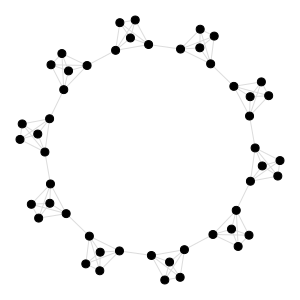

In [4]:
## n cliques of size s
def ringOfCliques(n,s):
    roc = ig.Graph.Erdos_Renyi(n=n*s,p=0)
    ## cliques
    for i in range(n):
        for j in np.arange(s*i,s*(i+1)):
            for k in np.arange(j+1,s*(i+1)):
                roc.add_edge(j,k)
    ## ring
    for i in range(n):
        if i>0:
            roc.add_edge(s*i-1,s*i)
        else:
            roc.add_edge(n*s-1,0)
    roc.vs['size'] = 8
    roc.vs['color'] = cls[2]
    roc.es['color'] = cls_edges
    return roc
roc = ringOfCliques(10,5)
#ig.plot(roc,'ring_3.eps',bbox=(0,0,300,300))     
ig.plot(roc,bbox=(0,0,300,300))        

/Users/user/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/user/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


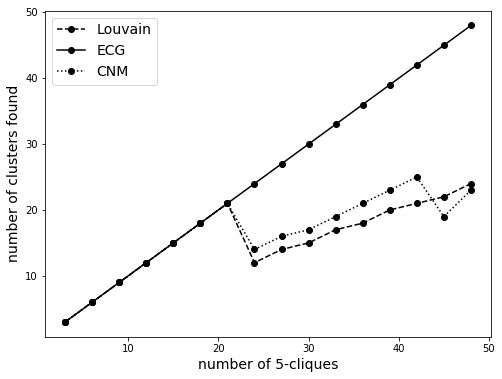

In [5]:
L = []
s = 5
for n in np.arange(3,50,3):
    roc = ringOfCliques(n,s)
    ml = np.max(roc.community_multilevel().membership)+1
    ec = np.max(roc.community_ecg().membership)+1
    cnm = np.max(roc.community_fastgreedy().as_clustering().membership)+1
    L.append([n,ml,ec,cnm])
D = pd.DataFrame(L,columns=['n','Louvain','ECG','CNM'])
plt.figure(figsize=(8,6))
plt.plot(D['n'],D['Louvain'],'--o',color='black',label='Louvain')
plt.plot(D['n'],D['ECG'],'-o',color='black',label='ECG')
plt.plot(D['n'],D['CNM'],':o',color='black',label='CNM')

plt.xlabel('number of '+str(s)+'-cliques',fontsize=14)
plt.ylabel('number of clusters found',fontsize=14)
plt.legend(fontsize=14);

#### For S = 7

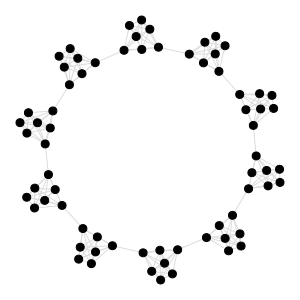

In [7]:
## n cliques of size s
def ringOfCliques(n,s):
    roc = ig.Graph.Erdos_Renyi(n=n*s,p=0)
    ## cliques
    for i in range(n):
        for j in np.arange(s*i,s*(i+1)):
            for k in np.arange(j+1,s*(i+1)):
                roc.add_edge(j,k)
    ## ring
    for i in range(n):
        if i>0:
            roc.add_edge(s*i-1,s*i)
        else:
            roc.add_edge(n*s-1,0)
    roc.vs['size'] = 8
    roc.vs['color'] = cls[2]
    roc.es['color'] = cls_edges
    return roc
roc = ringOfCliques(10,7)   
ig.plot(roc,bbox=(0,0,300,300))        

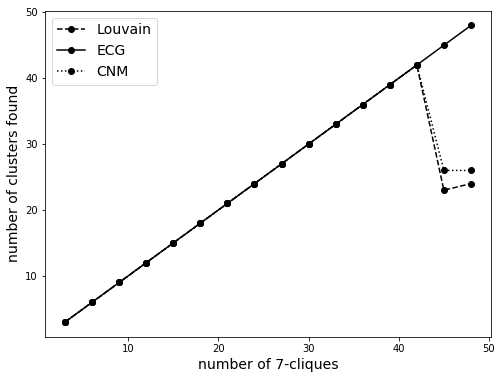

In [8]:
L = []
s = 7
for n in np.arange(3,50,3):
    roc = ringOfCliques(n,s)
    ml = np.max(roc.community_multilevel().membership)+1
    ec = np.max(roc.community_ecg().membership)+1
    cnm = np.max(roc.community_fastgreedy().as_clustering().membership)+1
    L.append([n,ml,ec,cnm])
D = pd.DataFrame(L,columns=['n','Louvain','ECG','CNM'])
plt.figure(figsize=(8,6))
plt.plot(D['n'],D['Louvain'],'--o',color='black',label='Louvain')
plt.plot(D['n'],D['ECG'],'-o',color='black',label='ECG')
plt.plot(D['n'],D['CNM'],':o',color='black',label='CNM')

plt.xlabel('number of '+str(s)+'-cliques',fontsize=14)
plt.ylabel('number of clusters found',fontsize=14)
plt.legend(fontsize=14);